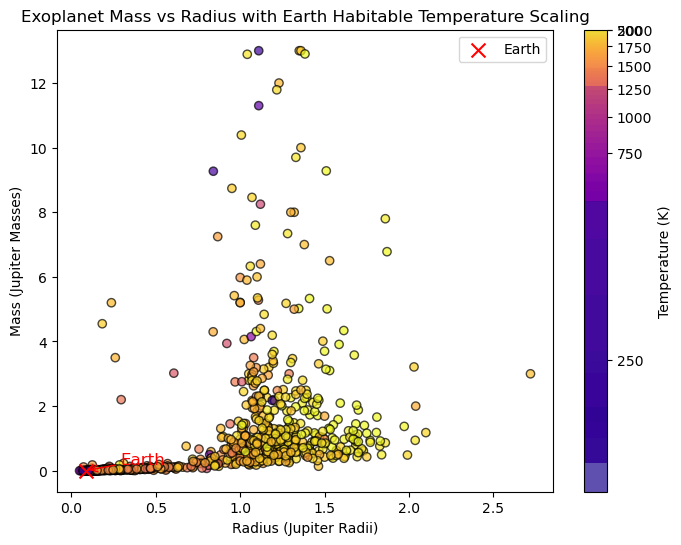

In [1]:
import xml.etree.ElementTree as ET
import gzip
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

# Load the uploaded systems.xml.gz file
file_path = r"C:\Users\Orion\Downloads\systems.xml.gz"

# Parse the XML data
with gzip.open(file_path, 'rb') as f:
    oec = ET.parse(f)

# Extract only valid exoplanets (excluding stars and brown dwarfs) with no missing data
filtered_planet_entries = []
for planet in oec.findall(".//planet"):
    mass = planet.findtext("mass")
    radius = planet.findtext("radius")
    temperature = planet.findtext("temperature")
    is_star = planet.findtext("spectraltype")  # Check if the object has a spectral type

    # Ensure all three values exist and filter out stars and brown dwarfs
    if mass and radius and temperature and not is_star:
        try:
            mass = float(mass)
            radius = float(radius)
            temperature = float(temperature)

            # Exclude brown dwarfs (>13 Jupiter masses)
            if mass <= 13:
                filtered_planet_entries.append((radius, mass, temperature))
        except ValueError:
            continue  # Skip entries with invalid data
            
# Separate data into lists
if filtered_planet_entries:
    radii, masses, temperatures = zip(*filtered_planet_entries)

    # Earth's approximate values for reference
    earth_radius = 0.0892  # Jupiter radii
    earth_mass = 0.00315  # Jupiter masses

    # Define a custom normalization function that applies to arrays
    class CustomLogNorm(mcolors.Normalize):
        def __init__(self, vmin=150, vmax=500, non_habitable_vmin=50, non_habitable_vmax=2000):
            self.habitable_range = (vmin, vmax)
            self.non_habitable_range = (non_habitable_vmin, non_habitable_vmax)
            super().__init__(vmin=non_habitable_vmin, vmax=non_habitable_vmax)

        def __call__(self, values, clip=None):
            values = np.asarray(values)  # Ensure it's an array

            # Apply linear scaling within the habitable range
            habitable_mask = (values >= self.habitable_range[0]) & (values <= self.habitable_range[1])
            habitable_scaled = (values - self.habitable_range[0]) / (self.habitable_range[1] - self.habitable_range[0])

            # Apply logarithmic scaling for non-habitable values
            with np.errstate(divide='ignore'):  # Ignore log(0) warnings
                log_scaled = np.log10(values / self.non_habitable_range[0]) / np.log10(self.non_habitable_range[1] / self.non_habitable_range[0])

            # Combine both scales
            result = np.where(habitable_mask, habitable_scaled, log_scaled)
            return result

    # Apply the new color scale
    norm = CustomLogNorm()

    # Create scatter plot with the new color scale
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(radii, masses, c=temperatures, cmap="plasma", norm=norm, alpha=0.7, edgecolors="k")

    # Mark Earth's location
    plt.scatter(earth_radius, earth_mass, color='red', marker='x', s=100, label="Earth")
    plt.annotate("Earth", xy=(earth_radius, earth_mass), xytext=(earth_radius + 0.2, earth_mass + 0.2),
                 arrowprops=dict(arrowstyle="->", color="red"), fontsize=12, color="red")

    # Color bar for temperature
    cbar = plt.colorbar(scatter)
    cbar.set_label("Temperature (K)")

    # Labels and title
    plt.xlabel("Radius (Jupiter Radii)")
    plt.ylabel("Mass (Jupiter Masses)")
    plt.title("Exoplanet Mass vs Radius with Earth Habitable Temperature Scaling")

    # Show plot
    plt.legend()
    plt.show()
    
else:
    print("No valid planet data found after strict filtering.")